**Установка библиотек**

In [34]:

%pip install pandas numpy tensorflow keras matplotlib seaborn regex

%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


**Импорт библиотек**

In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from collections import Counter
import os

**Подавление предупреждений TF (опционально)**

In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Настройка визуализации**

In [41]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

**Создание папки для результатов** 

In [42]:
os.makedirs('results', exist_ok=True)

**Загрузка датасета**


In [43]:
df = pd.read_csv('rusentitweet_full.csv')
print(f"Загружено твитов: {len(df)}")

df['text_length'] = df['text'].astype(str).apply(len)

Загружено твитов: 13392


**2.1 Визуализация характеристик датасета**

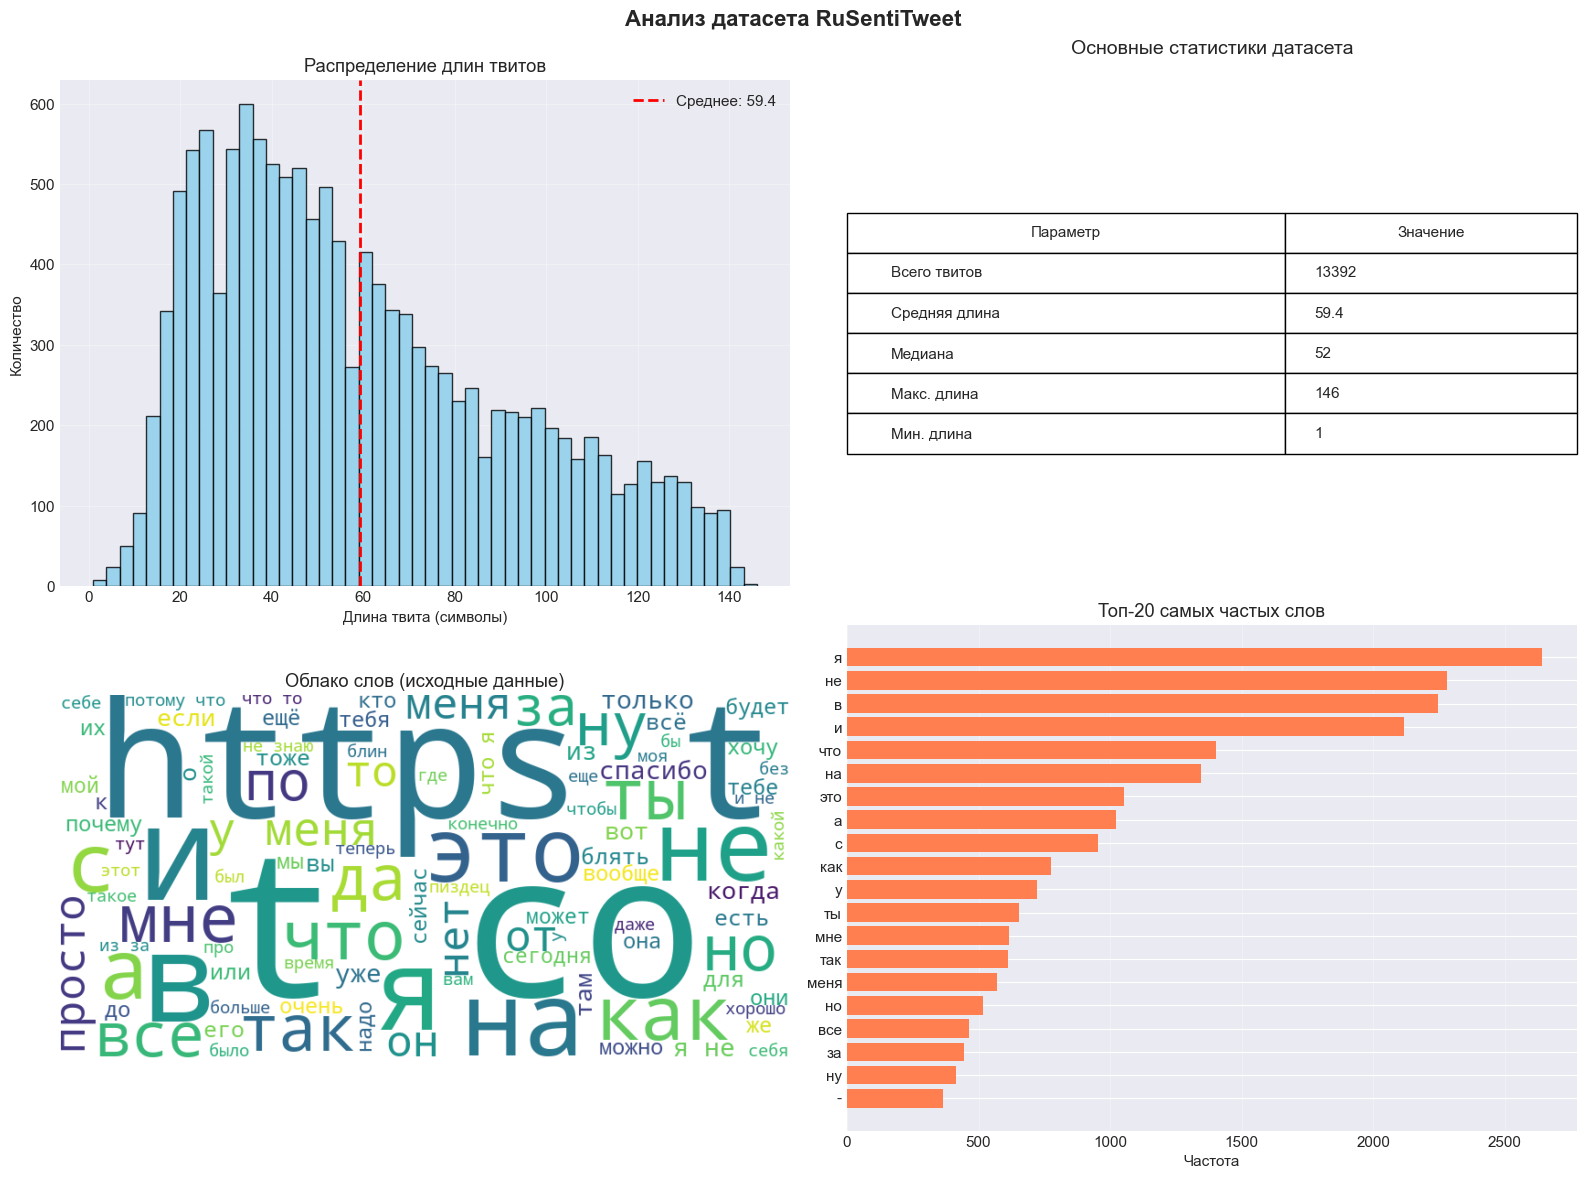

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ датасета RuSentiTweet', fontsize=16, fontweight='bold')

# 1. Гистограмма длин твитов
axes[0, 0].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {df["text_length"].mean():.1f}')
axes[0, 0].set_xlabel('Длина твита (символы)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].set_title('Распределение длин твитов')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Таблица статистики
stats = {
    'Всего твитов': len(df),
    'Средняя длина': f"{df['text_length'].mean():.1f}",
    'Медиана': f"{df['text_length'].median():.0f}",
    'Макс. длина': df['text_length'].max(),
    'Мин. длина': df['text_length'].min()
}
axes[0, 1].axis('off')
table_data = [[k, v] for k, v in stats.items()]
table = axes[0, 1].table(cellText=table_data,
                         colLabels=['Параметр', 'Значение'],
                         cellLoc='left', loc='center',
                         colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
axes[0, 1].set_title('Основные статистики датасета', fontsize=14, pad=20)

# 3. Облако слов
text_all = ' '.join(df['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='viridis').generate(text_all)
axes[1, 0].imshow(wordcloud, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Облако слов (исходные данные)')

# 4. Топ-20 самых частых слов — ИСПРАВЛЕНО!
all_text = ' '.join(df['text'].astype(str))        # Сначала объединяем
words = all_text.lower().split()                   # Потом lower() и split()
word_freq = Counter(words).most_common(20)
words_list, counts = zip(*word_freq)

axes[1, 1].barh(range(len(words_list)), counts, color='coral')
axes[1, 1].set_yticks(range(len(words_list)))
axes[1, 1].set_yticklabels(words_list)
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel('Частота')
axes[1, 1].set_title('Топ-20 самых частых слов')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('results/01_dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Предобработка текста**

In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)      # Удаляем ссылки
    text = re.sub(r'@\w+', '', text)                # Удаляем упоминания (опционально)
    text = re.sub(r'#\w+', '', text)                # Удаляем хештеги (опционально)
    text = re.sub(r'[^\w\s\u0400-\u04FF]', '', text)  # Оставляем только буквы и пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

texts_cleaned = [clean_text(t) for t in df['text'].astype(str) if len(clean_text(t)) > 5]

print(f"Текстов после очистки: {len(texts_cleaned)}")

# Пример до/после
sample_idx = 0
print(f"\nДО: {df['text'].iloc[sample_idx]}")
print(f"ПОСЛЕ: {texts_cleaned[sample_idx] if sample_idx < len(texts_cleaned) else 'N/A'}")

Текстов после очистки: 12737

ДО: @varlamov @McFaul На
ПОСЛЕ: велл они всё равно что мусор так что ничего страшного


**ТОКЕНИЗАЦИЯ (WORD-LEVEL)**

In [51]:
max_vocab = 8000  # Уменьшено для стабильности
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_cleaned)

vocab_size = max_vocab
max_sequence_len = 20  # Хороший баланс контекста и памяти

print(f"Размер словаря: {vocab_size}")
print(f"Макс. длина последовательности: {max_sequence_len}")

# Создание n-gram последовательностей
input_sequences = []
for line in texts_cleaned:
    token_list = tokenizer.texts_to_sequences([line])[0]
    if len(token_list) < 2:
        continue
    for i in range(2, len(token_list) + 1):
        n_gram = token_list[:i]
        input_sequences.append(n_gram)

print(f"Создано последовательностей: {len(input_sequences)}")

# Паддинг
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

X = input_sequences[:, :-1]   # Все кроме последнего
y = input_sequences[:, -1]    # Последний токен — цель

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")

Размер словаря: 8000
Макс. длина последовательности: 20
Создано последовательностей: 84034
Форма X: (84034, 19)
Форма y: (84034, 8000)


**Модель LSTM**

In [52]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_sequence_len-1),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(vocab_size // 2, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5')]
)

model.summary()

# Визуализация архитектуры
try:
    plot_model(model, to_file='results/04_model_architecture.png',
               show_shapes=True, show_layer_names=True, dpi=300)
    print("Схема архитектуры сохранена")
except:
    print("Не удалось сохранить схему (graphviz не установлен)")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 128)           1024000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 19, 256)           263168    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 19, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               142800    
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 4000)              404000    
                                                      

**Обучение**

In [32]:

history = model.fit(
    X, y,
    batch_size=128,
    epochs=30,  
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
711/711 [==============================] - 158s 222ms/step - loss: 4.9729 - accuracy: 0.2937 - val_loss: 5.1837 - val_accuracy: 0.3001
Epoch 2/30
711/711 [==============================] - 154s 217ms/step - loss: 4.8293 - accuracy: 0.2965 - val_loss: 5.2018 - val_accuracy: 0.3010
Epoch 3/30
711/711 [==============================] - 159s 224ms/step - loss: 4.6942 - accuracy: 0.3001 - val_loss: 5.2479 - val_accuracy: 0.2996
Epoch 4/30
711/711 [==============================] - 149s 210ms/step - loss: 4.5586 - accuracy: 0.3035 - val_loss: 5.3211 - val_accuracy: 0.2983
Epoch 5/30
711/711 [==============================] - 155s 218ms/step - loss: 4.4218 - accuracy: 0.3066 - val_loss: 5.4478 - val_accuracy: 0.2982
Epoch 6/30
711/711 [==============================] - 155s 218ms/step - loss: 4.2801 - accuracy: 0.3100 - val_loss: 5.5627 - val_accuracy: 0.2966
Epoch 7/30
711/711 [==============================] - 157s 221ms/step - loss: 4.1293 - accuracy: 0.3151 - val_loss: 5.8028 -

**Анализ обучения**

C:\Users\Machcreator\AppData\Local\Temp\ipykernel_66492\4064139696.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


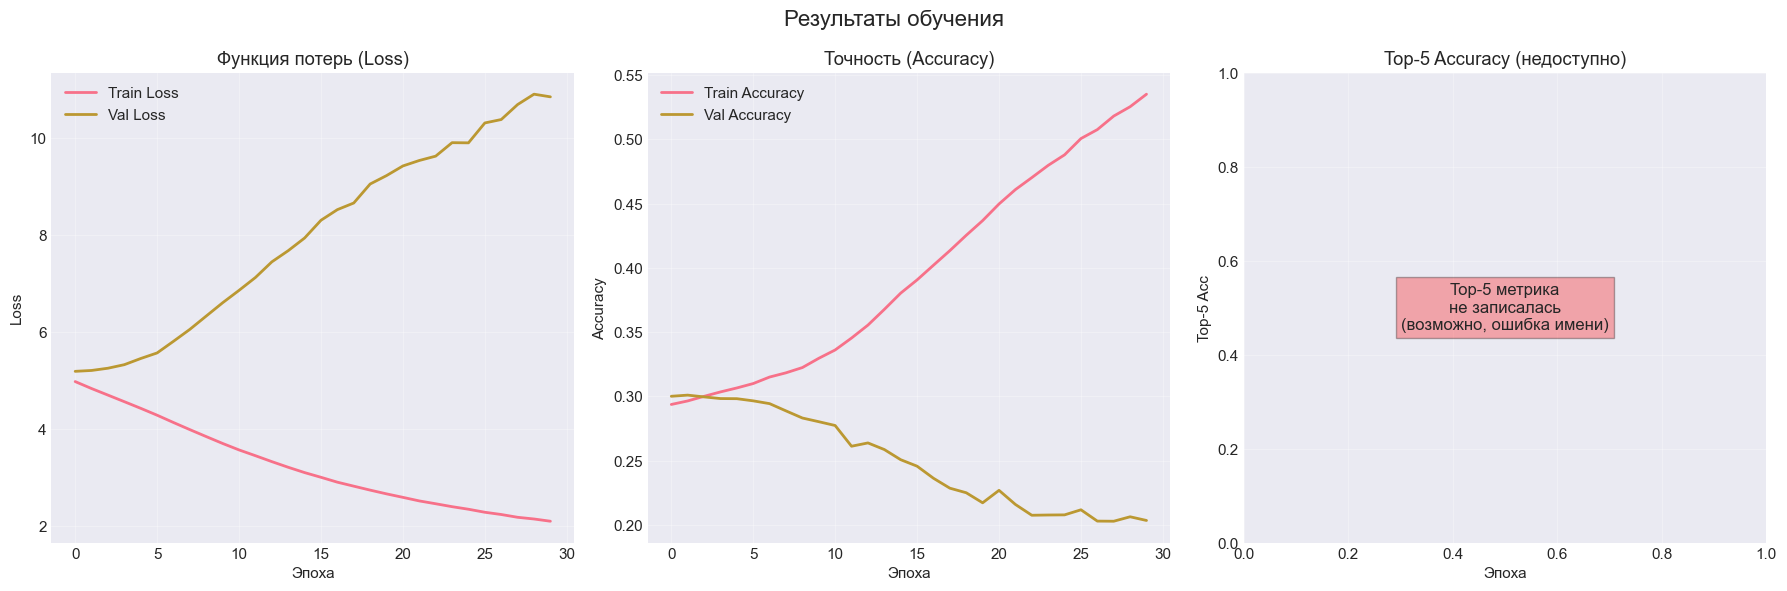

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Результаты обучения', fontsize=16)

# График 1: Loss (всегда есть)
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Функция потерь (Loss)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Accuracy (всегда есть)
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Точность (Accuracy)')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# График 3: Top-5 Accuracy — с проверкой имени
top5_key = None
val_top5_key = None
for key in history.history.keys():
    if 'top' in key.lower() and '5' in key and not key.startswith('val_'):
        top5_key = key
    if 'top' in key.lower() and '5' in key and key.startswith('val_'):
        val_top5_key = key

if top5_key and val_top5_key:
    axes[2].plot(history.history[top5_key], label='Train Top-5', linewidth=2)
    axes[2].plot(history.history[val_top5_key], label='Val Top-5', linewidth=2)
    axes[2].set_title('Top-5 Accuracy')
else:
    # Если Top-5 не записался — просто покажем дубликат Accuracy или пустой график
    axes[2].text(0.5, 0.5, 'Top-5 метрика\nне записалась\n(возможно, ошибка имени)', 
                 ha='center', va='center', transform=axes[2].transAxes, fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.3))
    axes[2].set_title('Top-5 Accuracy (недоступно)')

axes[2].set_xlabel('Эпоха')
axes[2].set_ylabel('Top-5 Acc')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/05_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

**Генерация поста**

In [54]:
def generate_post(seed_text, next_words=30, temperature=0.7):
    generated = seed_text.lower()
    
    for _ in range(next_words):
        # Токенизируем текущий текст
        token_list = tokenizer.texts_to_sequences([generated])[0]
        token_list = token_list[-(max_sequence_len-1):]  # Последние токены
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Предсказание вероятностей
        preds = model.predict(token_list, verbose=0)[0]
        
        # Temperature sampling
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + 1e-10) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Выбор следующего индекса
        next_index = np.random.choice(len(preds), p=preds)
        
        # Находим слово
        next_word = tokenizer.index_word.get(next_index, '')
        if next_word:
            generated += " " + next_word
    
    return generated.strip()

# Тестирование
print("\nПРИМЕРЫ ГЕНЕРАЦИИ:")
seeds = ["привет как дела", "сегодня", "россия", "я думаю что", "погода"]
for seed in seeds:
    print(f"\nSeed: '{seed}'")
    for t in [0.5, 0.8, 1.0]:
        print(f"  T={t}: {generate_post(seed, next_words=25, temperature=t)}")


ПРИМЕРЫ ГЕНЕРАЦИИ:

Seed: 'привет как дела'
  T=0.5: привет как дела поле тысячи опубликовано бэк пятнице дрын съела днём теперь леса моря шанс нужен спасииибо 37 гоё ограничения всë туризма нельзя повесить отказа речи младшей убийство
  T=0.8: привет как дела оказаться пожалуйста стрим посмотреть нарушает неть захотелось дистанционное хуа чё книг перерыва жалость денег результат обращаться дерево смотрятся классная чаще показывает севгу правильно льдом тви
  T=1.0: привет как дела баярлалаа дауны ирл грузчики смакотин посты мальчики таковым девчонки артём общаться токсик чик өөр байхаар 2х валуев счастьем нормальной конституцию нагрубила доеду жителям разных обидно

Seed: 'сегодня'
  T=0.5: сегодня реклама топилмагунча стали дышать большинства вопросответ отношения напоминают бесплатная глазу группу делам границы болей доброй бхгүй пить парка штоле всего galaxy дээ будут возле тихановская
  T=0.8: сегодня принуждение ааааааааааа сердца били вовой парней маск спрашивали привезут игнор

**Тестирование**

In [55]:
print("\n" + "="*60)
print("ПРИМЕРЫ ГЕНЕРАЦИИ")
print("="*60)

test_seeds = [
    "сегодня",
    "россия",
    "я думаю",
    "новости",
    "погода"
]

for seed in test_seeds:
    print(f"\n--- Seed: '{seed}' ---")
    
    # Разные температуры
    for temp in [0.5, 0.8, 1.2]:
        result = generate_post(seed, next_words=20, temperature=temp)
        print(f"T={temp}: {result}")


ПРИМЕРЫ ГЕНЕРАЦИИ

--- Seed: 'сегодня' ---
T=0.5: сегодня надпись оценилa унитаза появление сложно лентой свое назвали красота экономику украинцев вру позволь выпуска народом частью гей выиграл легко добрые
T=0.8: сегодня вторых сидели заказать нахер аккаунт поправки самоубийства дошло принтер башка нехватки слышат reliz пробили фандома переворачивает объясняет включить ту выхожу
T=1.2: сегодня отменила датак имена подружку раскрыли вонпиль любит ищу валуев суши обнаружена бабки чтоб спрашиваю многовато очередная му пила трусы чертовски

--- Seed: 'россия' ---
T=0.5: россия быстрее погоды ама везёт изменится хоол виноваты позвонить мамой нифига поехала днём версию станции столе красный смеюсь лучших турции играет
T=0.8: россия ссылка требуются үлд балконе гад стрёмная производителей сексуализацию тенглик честное скорейшего какойнибудь f симпатичная история винкс пониматьпоэтому куче смены light
T=1.2: россия хахахахахахаха м оборудование их берегите удален синдром посмотреть посмотрит

**ЛУЧШИЕ РЕЗУЛЬТАТЫ**

In [56]:
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ ПОСТЫ (оптимальная температура)")
print("="*60)

for i in range(5):
    seed = np.random.choice(["сегодня", "я считаю", "новости", "россия"])
    post = generate_post(seed, next_words=25, temperature=0.7)
    print(f"\n{i+1}. {post}")


ФИНАЛЬНЫЕ ПОСТЫ (оптимальная температура)

1. новости филантропии спонсор состояние ладно мелодия вторник подумает чэньцин нато одном существа опасны напишите короткие боевиков сос намджун настя залипать немножко катастрофа ебало бить кидайте чихшигнамайг

2. новости неплохо сдаю смены показать прислали штож энд какието говорила праведном германия предлагают лучшую пожалуйста вперёд карасики фестиваль звонит учитывая post похвально попали справишься трампом бляяять

3. сегодня ответственность относятся новеллы самоизоляции переехать прочитать гээд кьюриосити ведьма жены спросил василия дата услышал маленькую эту появляется беспредел надо сменила тьма можно нами столицы вилл

4. сегодня реинкарнация канкри новогодних ник него работали дожить выборах боевиков купила погуглите телегу подумал номинантов экономический парень диэнэй кружится попробую врач закладки краши ник вспоминать матчей

5. новости друзья странные кол национального спорить харсан посмеет пиццу болчихсон власовские поэз

**Сохранение модели**

In [57]:
model.save('post_generator_model.h5')
print("\n✓ Модель сохранена: post_generator_model.h5")

# Сохранение токенизатора
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Токенизатор сохранен: tokenizer.pkl")

C:\Users\Machcreator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



✓ Модель сохранена: post_generator_model.h5
✓ Токенизатор сохранен: tokenizer.pkl
